In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import pandas as pd
import glob


beta_max = 1.25
beta_min = 0.1

SR = 16000


In [10]:
xlims = np.array([[beta_min,beta_max],
                  [0.4,1.3],
                  [0.9,1.2]])

ylims = np.array([[0,0],            # Placeholder for beta                          0
                  [-2,0],           # Energy                                        1
                  [0,4],            # Energy squared !!(multiply by L**2)!!         2
                  [-0.02,0.02],     # Magnetization                                 3
                  [0,3],            # Magnetization squared                         4
                  [0,0.25],         # Absolute magnetization                        5
                  [0,2.5],          # Specific heat                                 6
                  [0,0.5],          # Susceptibility                                7  
                  [0,1],            # Cluster size !!(multiply by L**2)!!           8
                  [0,0.1],          # NW cluster size !!(multiply by L**2)!!        9
                  [0,1],            # Wrap prob. (neither)                          10
                  [0.15,0.26],      # Dominant Wavenumber                           11
                  [0,1],            # Dominant Amplitude   !!(multiply by L)!!      12
                  [0,1],            # Rho_T   !!(multiply by R)!!                   13
                  [0,1],            # Unique Families   !!(multiply by R)!!         14
                  [0,0.15],         # Overlap                                       15
                  [0,0.8],          # Absolute Overlap                              16
                  [0,0.3],          # Overlap Variance                              17
                  [0,2],            # Free Energy                                   18
                  [0,1],            # Wrap prob. (Z-only)                           19
                  [0,1],            # Wrap prob. (X-only)                           20
                  [0,1],            # Wrap prob. (Both)                             21
                  [0,1],            # Cluster size (Z-wrap) !!(multiply by L**2)!!  22
                  [0,1],            # Cluster size (X-wrap) !!(multiply by L**2)!!  23
                  [0,1],            # Cluster size (Both)   !!(multiply by L**2)!!  24
])

In [55]:
def getObs(fname, qty_number):
    df = pd.read_csv(fname)
    betas = df["Beta"]
    header = list(df)[qty_number]
    observable = df[header]
    
    return observable

def getFE(fname):
    df = pd.read_csv(fname)
    betas = df["Beta"]
    FE = df["Free Energy"] # need to manipulate F a little, based on what is calculated in C++
    
    return FE

In [21]:
def getUnbiasedEstimate(kappa,L,R,mode,quantity):
    # This function returns the unbiased estimator for an observable, as well as its standard error which is found using the bootstrap method.
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Documents/ANNNI/populationannealing/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    print(f"No. of datasets = {len(files)}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    header = list(df_example)[quantity]
    if L == 96:
        tail = 0
    else:
        tail = 0

    if quantity != 18 and quantity != 6:

        obs_matrix = np.zeros(shape = (len(files), len(betas)))
        FE_weights = np.zeros(shape = (len(files), len(betas)))
        FE_weight_denoms = np.zeros(shape = len(betas))
        FE_matrix = np.zeros(shape = (len(files), len(betas)))

        for i in range(len(files)):
            df = pd.read_csv(files[i])
            df.drop(df.tail(tail).index,inplace=True)
            betas = np.array(df["Beta"])
            observable = df[header]
            FE = df["Free Energy"] ### DIVIDE BY NUMBER OF SPINS TO MAKE NUMBERS MANAGEABLE --> Is this even OK to do? probably yes just to get weightings
            # print(FE)
            obs_matrix[i,:] = observable
            FE_matrix[i,:] = FE
            for j in range(len(betas)):
                FE_weights[i,j] = np.exp(FE_matrix[i,j] - max(FE_matrix[:,j]))
                FE_weight_denoms[j] += FE_weights[i,j]
    
        for i in range(len(betas)):
            FE_weights[:,i] /= FE_weight_denoms[i]
        
        unbiased_obs = np.zeros(len(betas))
        for i in range(len(files)):
            unbiased_obs += obs_matrix[i,:] * FE_weights[i,:]
        
    if quantity == 6:

        ene_matrix = np.zeros(shape = (len(files), len(betas)))
        ene_sq_matrix = np.zeros(shape = (len(files), len(betas)))
        obs_matrix = np.zeros(shape = (len(files), len(betas)))
        FE_weights = np.zeros(shape = (len(files), len(betas)))
        FE_weight_denoms = np.zeros(shape = len(betas))
        FE_matrix = np.zeros(shape = (len(files), len(betas)))
        for i in range(len(files)):
            df = pd.read_csv(files[i])
            df.drop(df.tail(tail).index,inplace=True)
            betas = np.array(df["Beta"])
            energy = df["Energy"]
            energy_sq = df["Energy Squared"]
            FE = df["Free Energy"]
            ene_matrix[i,:] = energy
            ene_sq_matrix[i,:] = energy_sq
            obs_matrix[i,:] = (energy_sq - energy**2)*betas**2
            FE_matrix[i,:] = FE

            for j in range(len(betas)):
                FE_weights[i,j] = np.exp(FE_matrix[i,j] - max(FE_matrix[:,j]))
                FE_weight_denoms[j] += FE_weights[i,j]
    
        for i in range(len(betas)):
            FE_weights[:,i] /= FE_weight_denoms[i]
        
        unbiased_obs = np.zeros(len(betas))
        unbiased_ene = np.zeros(len(betas))
        unbiased_ene_sq = np.zeros(len(betas))
        for i in range(len(files)):
            unbiased_ene += ene_matrix[i,:] * FE_weights[i,:]
            unbiased_ene_sq += ene_sq_matrix[i,:] * FE_weights[i,:]
        
        L_typical = [32,48,96]
        for i in L_typical:
            if np.abs(L - i) < 5:
                L = i
        unbiased_obs = (L**2)*(unbiased_ene_sq - (unbiased_ene)**2)*betas**2
        
    ### Bootstrap method
    B = 100

    se_obs_bootstrap = np.zeros(shape = len(betas))
    bootmean_std = np.zeros(len(unbiased_obs))
    for i in range(len(betas)):
        sample = obs_matrix[:,i]
        boot_means = []
        for _ in range(B):
            bootsample = np.random.choice(sample,size=len(sample), replace=True)
            boot_means.append(bootsample.mean())
        bootmean_std[i] = np.std(boot_means,ddof = 1)
    se_obs_bootstrap = bootmean_std
    
    return unbiased_obs, se_obs_bootstrap

In [5]:
def findLocalMaxima(ue, se):

    for i in range(1,len(betas)-1):
        if ue[i] > ue[i-1] and ue[i] >ue[i+1] and betas[i] < 1.25:
            print(f"{ue[i]} +/- {se[i]}, beta = {betas[i]}")

In [5]:
def getUnbiasedFE(kappa,L,R,mode, minusbeta = False): ### This returns F, just F. The C++ program returns -beta*F
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Documents/ANNNI/populationannealing/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    FE_matrix = np.empty(shape = (len(files), len(betas)))
    unbiased_FE = np.empty(len(betas))
    for i in range(len(files)):
        # print(files[i])
        df = pd.read_csv(files[i])
        FE = df["Free Energy"] # need to manipulate F a little, based on what is calculated in C++
        FE_matrix[i,:] = FE
    
    for i in range(len(betas)):
        # unbiased_FE[i] = np.log((1/len(files))*np.sum(np.exp(FE_matrix[:,i]))) # Has overflow from too large numbers
        unbiased_FE[i] = -np.log(len(files)) + np.max(FE_matrix[:,i]) + np.log(np.sum(np.exp(FE_matrix[:,i] - np.max(FE_matrix[:,i]))))
        if minusbeta == False:
            unbiased_FE[i] *= -1/betas[i]

    ### Bootstrap method
    B = 100
    se_FE_bootstrap = np.zeros(shape = len(betas))
    bootmean_std = np.zeros(len(unbiased_FE))
    for i in range(len(betas)):
        sample = FE_matrix[:,i]
        boot_means = []
        for _ in range(B):
            bootsample = np.random.choice(sample,size=len(sample), replace=True)
            boot_means.append(bootsample.mean())
        bootmean_std[i] = np.std(boot_means,ddof = 1)
    se_FE_bootstrap = bootmean_std

    return unbiased_FE, se_FE_bootstrap

In [7]:
def plotWrappingQuantities(kappa,L,R):
    kappa = 0.6
    L = 48
    R = 16000
    # df_example = pd.read_csv(files[0])
    # header = list(df_example)[quantity]
    # print(header)
    mode = "t"
    modestr = "Two Replica" if (mode == "t") else "Wolff"

    unbiased_xbarzbar, se_xbarzbar = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 10)
    unbiased_xbarz, se_xbarz = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 19)
    unbiased_xzbar, se_xzbar = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 20)
    unbiased_xz, se_xz = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 21)

    unbiased_total = unbiased_xbarzbar + unbiased_xbarz + unbiased_xzbar + unbiased_xz
    se_total = se_xbarzbar + se_xbarz + se_xzbar + se_xz

    # Customize plot appearance
    plt.rc('text', usetex=False)  # Use LaTeX for all text
    plt.rc('font', family='serif', size=10)  # Use serif fonts with size 10
    plt.rc('axes', labelsize=12)  # Axis label size
    plt.rc('legend', fontsize=10)  # Legend font size

    fig, ax1 = plt.subplots(figsize=(7.5, 6))  # Adjust the figure size for the journal aspect ratio

    from matplotlib.cm import get_cmap
    colors = np.array(["#fa0707", "#050505", "#30fc03", "#0207fa", "#f757f2", "#0dffef", "#ffaa0d"])
    markers = ["x", "o", "^", "s", "*", "3"]



    ax1.errorbar(betas, unbiased_xbarzbar, se_xbarzbar,
                linewidth=0, elinewidth=0.8, 
                marker=markers[0], markersize=2, 
                color=colors[0], ecolor="black", 
                label=r"$P_{\bar{x}\bar{z}}$")

    ax1.errorbar(betas, unbiased_xbarz, se_xbarz,
                linewidth=0, elinewidth=0.8, 
                marker=markers[1], markersize=2, 
                color=colors[1], ecolor="black", 
                label=r"$P_{\bar{x}z}$")

    ax1.errorbar(betas, unbiased_xzbar, se_xzbar,
                linewidth=0, elinewidth=0.8, 
                marker=markers[2], markersize=2, 
                color=colors[2], ecolor="black", 
                label=r"$P_{x\bar{z}}$")

    ax1.errorbar(betas, unbiased_xz, se_xz,
                linewidth=0, elinewidth=0.8, 
                marker=markers[3], markersize=2, 
                color=colors[3], ecolor="black", 
                label=r"$P_{xz}$")

    ax1.errorbar(betas, unbiased_total, se_total,
                linewidth=0, elinewidth=0.8, 
                marker=markers[4], markersize=2, 
                color=colors[4], ecolor="black", 
                label=r"Total")
            


    # Axis labels
    ax1.set_xlabel(r"Inverse temperature $\beta$", fontsize=12)
    ax1.set_ylabel("Wrapping probabilities", fontsize=12)

    # Limits and grid
    ax1.set_xlim(0.2, 1.4)
    ax1.set_ylim(0,1.05)

    ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Title with LaTeX formatting
    # ax1.set_title(rf"Unbiased Estimator for wrapping probabilities with Standard Error" +f"\n"
    #               + rf"$\kappa = {kappa}$, $L = {L}$, $R = {R}$, {modestr}", fontsize=11)

    # Legend
    ax1.legend(loc='center right', frameon=True, markerscale = 2, prop={'size': 11})


    plt.tight_layout()
    from datetime import date
    datestr = date.today().strftime("%d%b%y")
    descriptor = f"wrapping-probs-{modestr}"
    print(datestr)
    if kappa == 0.6:
        kappafilestr = "k-0-6"
    elif kappa == 0:
        kappafilest = "k-0"
    plt.savefig(f"/Users/shanekeiser/Documents/ANNNI/figures/{datestr}_{descriptor}_{kappafilestr}_L-{L}_R-{R}.png", dpi=300)  # Save in high resolution
    plt.show()

In [8]:
def comparePopSize(kappa,L,R_vals, qty, xlim_size = 0):
    kappa = 0.6
    kappastr = f"{kappa:.2f}"
    R = R_vals[0]
    quantity = qty
    mode = "t"
    modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    header = list(df_example)[quantity]
    print(header)

    unbiased_observables = np.empty(shape = (len(betas),len(R_vals)))
    standard_errors = np.empty(shape = (len(betas),len(R_vals)))
    for i in range(len(R_vals)):
        unbiased_observables[:,i], standard_errors[:,i] = getUnbiasedEstimate(kappa = kappa, L = L, R = R_vals[i], mode = mode, quantity = quantity)
    
    # Customize plot appearance
    plt.rc('text', usetex=False)  # Use LaTeX for all text
    plt.rc('font', family='serif', size=10)  # Use serif fonts with size 10
    plt.rc('axes', labelsize=12)  # Axis label size
    plt.rc('legend', fontsize=10)  # Legend font size

    fig, ax1 = plt.subplots(figsize=(9, 6))  # Adjust the figure size for the journal aspect ratio

    # Design
    colors =  np.array(["#fa0707", "#363636", "#30fc03", "#0207fa","#f757f2","#0dffef"])#, "#f757f2", "#0dffef", "#ffaa0d"])
    ecolors = np.array(["#960404", "#050505", "#1c9701", "#01037d", "#f757e3","#0dff13"])
    markers = ["o", "v", "^", "s", "P", "X"]

    # S_times_R = 160000

    S_vals = SR/R_vals

    # Plot the first dataset with error bars
    for i in range(len(R_vals)):
        label = fr"R = {R_vals[i]}, S = {S_vals[i]}"#, $\epsilon$ = {e_vals[i]}"
        ax1.errorbar(betas, unbiased_observables[:,i], standard_errors[:,i], 
                    linewidth=0.1, elinewidth=0.8, 
                    marker=markers[i], markersize=1.5, 
                    color='none', ecolor=ecolors[i], 
                    mec = colors[i], mew = 0.5,
                    label=label)

    # Axis labels, limits and grid
    ax1.set_xlabel(r"Inverse temperature $\beta$", fontsize=12)
    ax1.set_ylabel(f"{header}", fontsize=12)
    ax1.set_xlim(xlims[xlim_size])
    ax1.set_ylim(ylims[quantity])
    ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Title with LaTeX formatting and Legend
    ax1.set_title(rf"Unbiased Estimator with Standard Error for {header}" +f"\n"
                + rf"$\kappa = {kappa}$, $L = {L}$", fontsize=11)
    ax1.legend(loc='upper left', frameon=True, markerscale = 4)

    if quantity == 11:
        L_max = L  # The largest L value
        start = int(L_max / 8) + 1
        end = int(L_max / 4) + 1
        fractions = np.arange(start, end + 1) / L_max
        ax1.hlines(y=fractions, xmin=0, xmax=2.5, linewidth=1, linestyle='dashed', alpha=0.6, color="black")
        ax1.set_yticks(fractions)
        ax1.set_yticklabels([f"{int(frac * L_max)}/{L_max}" for frac in fractions])
        ax1.set_ylabel(r"Wavenumber$/2\pi$", fontsize=12)

    # ax1.text(x = 0.325, y = 1.6, s = r"$\Delta \beta = 0.005$", bbox = dict(facecolor='yellow', alpha=0.5))
    # ax1.text(x = 0.55, y = 1.6, s = r"$\Delta \beta = 0.0005$",bbox = dict(facecolor='yellow', alpha=0.5))
    # ax1.vlines(x = [0.5], ymin = 0, ymax = 4, linestyle = 'dashed', alpha = 0.5)

    # plt.tight_layout()
    from datetime import date
    datestr = date.today().strftime("%d%b%y")
    descriptor = f"{header}-{modestr}"
    print(datestr)
    if kappa == 0.6:
        kappafilestr = "k-0-6"
    elif kappa == 0:
        kappafilestr = "k-0"
    plt.savefig(f"/Users/shanekeiser/Documents/ANNNI/figures/{datestr}_{descriptor}_{kappafilestr}_L-{L}_R-comparison.png", dpi=300)  # Save in high resolution
    plt.show()


In [26]:
def compareLatticeSize(kappa,L_vals,R, qty=1, xlim_size = 0):
    kappa = 0.6
    kappastr = f"{kappa:.2f}"
    L = L_vals[0]
    quantity = qty
    mode = "t"
    modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Documents/ANNNI/populationannealing/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    header = list(df_example)[quantity]
    print(header)

    unbiased_observables = np.empty(shape = (len(betas),len(L_vals)))
    standard_errors = np.empty(shape = (len(betas),len(L_vals)))
    for i in range(len(L_vals)):
        unbiased_observables[:,i], standard_errors[:,i] = getUnbiasedEstimate(kappa = kappa, L = L_vals[i], R = R, mode = mode, quantity = quantity)
    
    # Customize plot appearance
    plt.rc('text', usetex=False)  # Use LaTeX for all text
    plt.rc('font', family='serif', size=10)  # Use serif fonts with size 10
    plt.rc('axes', labelsize=12)  # Axis label size
    plt.rc('legend', fontsize=10)  # Legend font size

    fig, ax1 = plt.subplots(figsize=(9, 6))  # Adjust the figure size for the journal aspect ratio

    # Design
    colors =  np.array(["#fa0707", "#363636", "#30fc03", "#0207fa","#f757f2","#0dffef"])#, "#f757f2", "#0dffef", "#ffaa0d"])
    ecolors = np.array(["#960404", "#050505", "#1c9701", "#01037d", "#f757e3","#0dff13"])
    markers = ["o", "v", "^", "s", "P", "X"]

    # S_times_R = 160000
    S = SR/R

    # Plot the first dataset with error bars
    for i in range(len(L_vals)):
        label = fr"L = {L_vals[i]}, S = {S}"#, $\epsilon$ = {e_vals[i]}"
        ax1.errorbar(betas, unbiased_observables[:,i], standard_errors[:,i], 
                    linewidth=0.1, elinewidth=0,#.8, 
                    marker=markers[i], markersize=1.5, 
                    color='none', ecolor=ecolors[i], 
                    mec = colors[i], mew = 0.5,
                    label=label)

    # Axis labels, limits and grid
    ax1.set_xlabel(r"Inverse temperature $\beta$", fontsize=12)
    ax1.set_ylabel(f"{header}", fontsize=12)
    ax1.set_xlim(xlims[xlim_size])
    ax1.set_ylim(ylims[quantity])
    ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Title with LaTeX formatting and Legend
    ax1.set_title(rf"Unbiased Estimator with Standard Error for {header}" +f"\n"
                + rf"$\kappa = {kappa}$, $R = {R}$", fontsize=11)
    ax1.legend(loc='upper left', frameon=True, markerscale = 4)

    if quantity == 11:
        L_max = L_vals[-1]  # The largest L value
        start = int(L_max / 8) + 1
        end = int(L_max / 4) + 1
        fractions = np.arange(start, end + 1) / L_max
        ax1.hlines(y=fractions, xmin=0, xmax=2.5, linewidth=1, linestyle='dashed', alpha=0.6, color="black")
        ax1.set_yticks(fractions)
        ax1.set_yticklabels([f"{int(frac * L_max)}/{L_max}" for frac in fractions])
        ax1.set_ylabel(r"Wavenumber$/2\pi$", fontsize=12)

    # ax1.text(x = 0.325, y = 1.6, s = r"$\Delta \beta = 0.005$", bbox = dict(facecolor='yellow', alpha=0.5))
    # ax1.text(x = 0.55, y = 1.6, s = r"$\Delta \beta = 0.0005$",bbox = dict(facecolor='yellow', alpha=0.5))
    # ax1.vlines(x = [0.5], ymin = 0, ymax = 4, linestyle = 'dashed', alpha = 0.5)

    # plt.tight_layout()
    from datetime import date
    datestr = date.today().strftime("%d%b%y")
    descriptor = f"{header}-{modestr}"
    print(datestr)
    if kappa == 0.6:
        kappafilestr = "k-0-6"
    elif kappa == 0:
        kappafilestr = "k-0"
    plt.savefig(f"/Users/shanekeiser/Documents/ANNNI/figures/{datestr}_{descriptor}_{kappafilestr}_R-{R}_L-comparison.png", dpi=300)  # Save in high resolution
    plt.show()

In [10]:
def scatterData(kappa,L,R,beta,quantity=11):
    kappastr = f"{kappa:.2f}"
    quantity = quantity
    mode = "t"
    modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    
    obs_vals = np.zeros(len(files))
    FE_vals = np.zeros(len(files))
    betas = getObs(files[0],0)
    df = pd.read_csv(files[0])
    header = list(df)[quantity]
    if quantity == 11:
        header = r"Wavenumber/$2\pi$"
    beta_index = np.argmin(np.abs(beta - betas))
    beta = betas[beta_index]


    for i in range(len(files)):
        obs_vals[i] = getObs(files[i],quantity)[beta_index]
        FE_vals[i] = getFE(files[i])[beta_index]

    # Get weighted average of observable
    FE_weights = np.zeros(len(files))
    FE_weight_denom = 0
    for i in range(len(files)):
        FE_weights[i] = np.exp(FE_vals[i] - max(FE_vals))
        FE_weight_denom += FE_weights[i]
    for i in range(len(files)):
        FE_weights[i] /= FE_weight_denom
    unbiased_obs = 0
    for i in range(len(files)):
        unbiased_obs += obs_vals[i] * FE_weights[i]

    # Get weighted average of FE
    unbiased_FE = 0
    # unbiased_FE[i] = np.log((1/len(files))*np.sum(np.exp(FE_interp_vals[:,i]))) # Has overflow from too large numbers
    unbiased_FE = -np.log(len(files)) + np.max(FE_vals) + np.log(np.sum(np.exp(FE_vals - np.max(FE_vals))))
    # unbiased_FE *= -1/beta
    
        
    plt.scatter(x = FE_vals, y = obs_vals, marker = '.', color = 'b')
    plt.scatter(x = unbiased_FE, y = unbiased_obs, marker = 'o', color = 'r', label = 'Unbiased estimator point')
    plt.xlabel(r'$-\beta F$')
    S = int(SR/R)
    M = len(files)
    title = fr"Scatter plot of {M} trials for $\beta$ = {beta:.5f}" + f"\n" + fr"R = {R}, fixed annealing schedule, # of Sweeps = {S}" + f"\n" + fr"L = {L}, $\kappa$ = {kappa}"

    plt.ylabel(header)
    plt.title(title)
    plt.legend(loc = 'upper left')
    descriptor = "scatter-domfreq-FE"
    from datetime import date
    datestr = date.today().strftime("%d%b%y")
    if kappa == 0.6:
        kappafilestr = "k-0-6"
    elif kappa == 0:
        kappafilestr = "k-0"
    plt.tight_layout()
    plt.savefig(f"/Users/shanekeiser/Documents/ANNNI/figures/{datestr}_{descriptor}_{kappafilestr}_L-{L}_R-{R}.png", dpi=300)  # Save in high resolution
    plt.show()

In [11]:
def compareFEs(kappa,L,R_vals):
    kappastr = f"{kappa:.2f}"
    mode = "t"
    modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R_vals[0]}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    
    unbiased_FEs = np.zeros((len(R_vals),len(betas)))
    se_FEs = np.zeros((len(R_vals),len(betas)))
    for i in range(len(R_vals)):
        unbiased_FEs[i,:], se_FEs[i,:] = getUnbiasedFE(kappa,L,R_vals[i],'t')
    
    ### Set one as the baseline or zero, we'll take the last population size

    for i in range(len(R_vals)):
        unbiased_FEs[i,:] -= unbiased_FEs[-1,:]

    # Design
    colors =  np.array(["#fa0707", "#363636", "#30fc03", "#0207fa","#f757f2","#0dffef"])#, "#f757f2", "#0dffef", "#ffaa0d"])
    ecolors = np.array(["#960404", "#050505", "#1c9701", "#01037d", "#f757e3","#0dff13"])
    markers = ["o", "v", "^", "s", "P", "X"]
    
    # Plot the first dataset with error bars
    fig, ax1 = plt.subplots(figsize=(9, 6))  # Adjust the figure size for the journal aspect ratio
    for i in range(len(R_vals)):
        ax1.errorbar(betas, unbiased_FEs[i,:], se_FEs[i,:], 
                    linewidth=0, elinewidth=0.8, 
                    marker=markers[i], markersize=1, 
                    mfc='none', mec = colors[i], ecolor=ecolors[i], 
                    label=f"R = {R_vals[i]}")
    plt.legend(loc = 'lower left')
    plt.title(fr"Comparison of Free energy for $\kappa$ = {kappa}, L = {L}")
    popstring = "{" + f"R = {R_vals[-1]}" + "}"
    plt.ylabel(fr"Free energy minus baseline $F - F_{popstring}$")
    plt.xlabel(r"Inverse temperature $\beta$")
    descriptor = "FE_R-comparison"
    from datetime import date
    datestr = date.today().strftime("%d%b%y")
    if kappa == 0.6:
        kappafilestr = "k-0-6"
    elif kappa == 0:
        kappafilestr = "k-0"
    plt.savefig(f"/Users/shanekeiser/Documents/ANNNI/figures/{datestr}_{descriptor}_{kappafilestr}_L-{L}.png", dpi=300)  # Save in high resolution
    plt.show()

In [12]:
def peak_widths(betas, data, peaks, rel_height=0.5):

    widths = []
    left_markers = []
    right_markers = []

    for peak in peaks:
        peak_height = data[peak]
        target_height = rel_height * peak_height

        # Find the left intersection
        left_indices = np.where(data[:peak] <= target_height)[0]
        if len(left_indices) == 0:
            left_marker = betas[0]  # No intersection found, use first x-coordinate
        else:
            left_marker = betas[left_indices[-1]]  # Use the closest lower index

        # Find the right intersection
        right_indices = np.where(data[peak:] <= target_height)[0]
        if len(right_indices) == 0:
            right_marker = betas[-1]  # No intersection found, use last x-coordinate
        else:
            right_marker = betas[peak + right_indices[0]]  # Use the closest higher index

        # Calculate the width
        width = right_marker - left_marker

        # Append results
        widths.append(width)
        left_markers.append(left_marker)
        right_markers.append(right_marker)
        zeros = np.zeros(len(widths))

    return zeros, np.array(widths), np.array(left_markers), np.array(right_markers)
            


In [86]:
from scipy.signal import find_peaks
import matplotlib.table as tbl
def getPeakWidths(kappa,L,R, xlim_size = 0):
    kappastr = f"{kappa:.2f}"
    quantity = 6
    mode = "t"
    modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df_example = pd.read_csv(files[0])
    betas = df_example["Beta"]
    header = list(df_example)[quantity]
    print(header)

    unbiased_observables = np.empty(shape = (len(betas)))
    standard_errors = np.empty(shape = (len(betas)))
    unbiased_observables, standard_errors = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = quantity)
    
    # Customize plot appearance
    plt.rc('text', usetex=False)  # Use LaTeX for all text
    plt.rc('font', family='serif', size=10)  # Use serif fonts with size 10
    plt.rc('axes', labelsize=12)  # Axis label size
    plt.rc('legend', fontsize=10)  # Legend font size

    fig, ax1 = plt.subplots(figsize=(9, 6))  # Adjust the figure size for the journal aspect ratio

    # Design
    colors =  np.array(["#fa0707", "#363636", "#30fc03", "#0207fa","#f757f2","#0dffef"])#, "#f757f2", "#0dffef", "#ffaa0d"])
    ecolors = np.array(["#960404", "#050505", "#1c9701", "#01037d", "#f757e3","#0dff13"])
    markers = ["o", "v", "^", "s", "P", "X"]

    # S_times_R = 160000
    S = SR/R

    ### PEAK WIDTHS
    peaks, _ = find_peaks(unbiased_observables, prominence = 0.8)#, distance=100)
    results_half = peak_widths(betas, unbiased_observables, peaks, rel_height=0.5)
    beta_peaks = np.zeros(len(peaks))
    for i in range(len(peaks)):
        beta_peaks[i] = betas[peaks[i]]
    print(f"Peaks at beta = {beta_peaks}")
    print(f"Heights at resp. peaks = {unbiased_observables[peaks]}")
    print(f"Peak widths = {results_half[1]}")
    print(peaks)

    # Plot the first dataset with error bars
    ax1.errorbar(betas, unbiased_observables, standard_errors, 
                linewidth=0.1, elinewidth=0,#.8, 
                marker=markers[0], markersize=1.5, 
                color='none', ecolor=ecolors[0], 
                mec = colors[0], mew = 0.5)#, label=label)
    
    ax1.scatter(betas[peaks], unbiased_observables[peaks], marker = "x", color = 'k')
    for i in range(len(results_half[1])):
        ax1.hlines(y = unbiased_observables[peaks[i]]/2, xmin = results_half[2][i], 
                   xmax = results_half[3][i], color="C2")

    # Axis labels, limits and grid
    ax1.set_xlabel(r"Inverse temperature $\beta$", fontsize=12)
    ax1.set_ylabel(f"{header}", fontsize=12)
    ax1.set_xlim(xlims[xlim_size])
    ax1.set_ylim(ylims[quantity])
    ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Title with LaTeX formatting and Legend
    ax1.set_title(rf"Unbiased Estimator with Standard Error for {header}" +f"\n"
                + rf"$\kappa = {kappa}$, $R = {R}$, $L = {L}$", fontsize=11)
    # ax1.legend(loc='upper left', frameon=True, markerscale = 4)


    fig.tight_layout()

    plt.show()

In [87]:
### CHECKER for beta faults

kappa = 0.6
kappastr = f"{kappa:.2f}"
L = 48
R = 800
quantity = 6
mode = "t"
modestr = "Two Replica Method" if (mode == "t") else "Wolff Method"
modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
filepattern = f"emcx_data_*"
files = glob.glob(f"{dirpath}/{filepattern}")
tail = 0
for i in range(len(files)):
    # betas = getObs(files[0],0)
    df = pd.read_csv(files[i])
    df.drop(df.tail(tail).index,inplace=True)
    betas = np.array(df["Beta"])
    if np.any(betas[1:] < betas[:-1]):
        print("betas are not in order!" + f"{files[i]}")
    if betas.ndim != 1:
        print("beta is not 1d!")

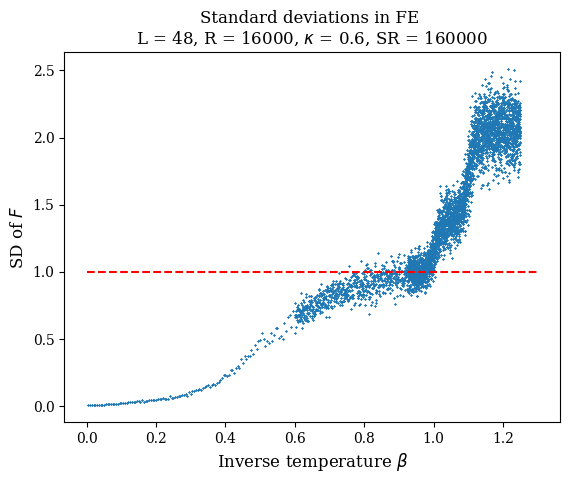

In [96]:
# SD Scatter
R = 16000
L=48
B=100
kappa=0.6
kappastr = f"{kappa:.2f}"
modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
filepattern = f"emcx_data_*"
files = glob.glob(f"{dirpath}/{filepattern}")
df_example = pd.read_csv(files[0])
betas = df_example["Beta"]
ue, se = getUnbiasedFE(kappa,L,R,'t')
plt.scatter(betas, se*np.sqrt(B), marker = 'x', s = 0.5)
plt.hlines(1, xmin = 0, xmax = 1.3, linestyle='--', color = 'r')
plt.ylabel(r'SD of $F$')
plt.xlabel(r'Inverse temperature $\beta$')
plt.title('Standard deviations in FE \n' + fr'L = {L}, R = {R}, $\kappa$ = {kappa}, SR = {SR}')
plt.show()

For this plot, the 'largest' value implies the lowest free energy at a point.


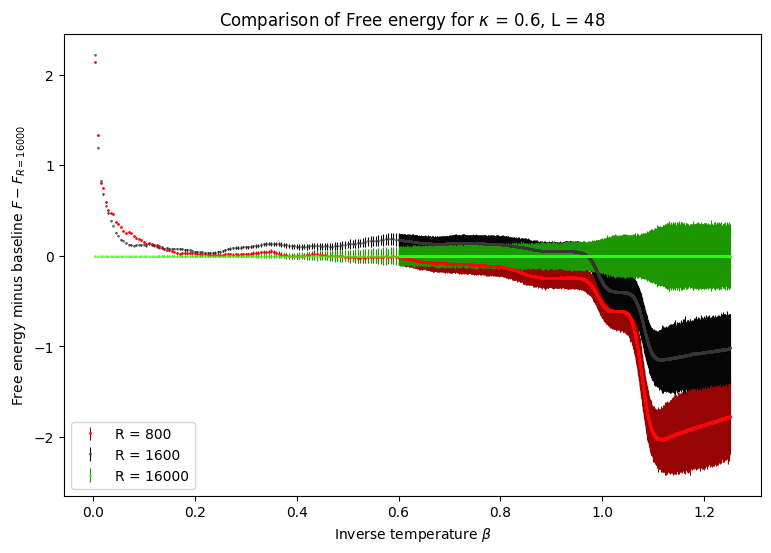

In [19]:
R_arr = np.array([800,1600,16000])
print("For this plot, the 'largest' value implies the lowest free energy at a point.")
compareFEs(0.6, 48, R_arr)

Energy
No. of datasets = 1
14Jan25


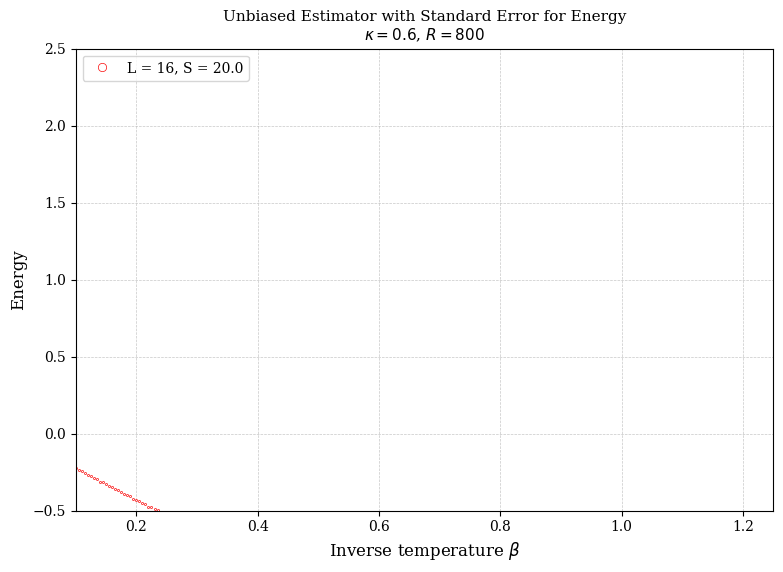

In [27]:
# run the functions

L_arr = np.array([32,48,96])
L_arr = np.array([16])
compareLatticeSize(0.6, L_arr, 800, qty = 1)

Absolute Magnetization
No. of datasets = 145
No. of datasets = 163
No. of datasets = 129
13Jan25


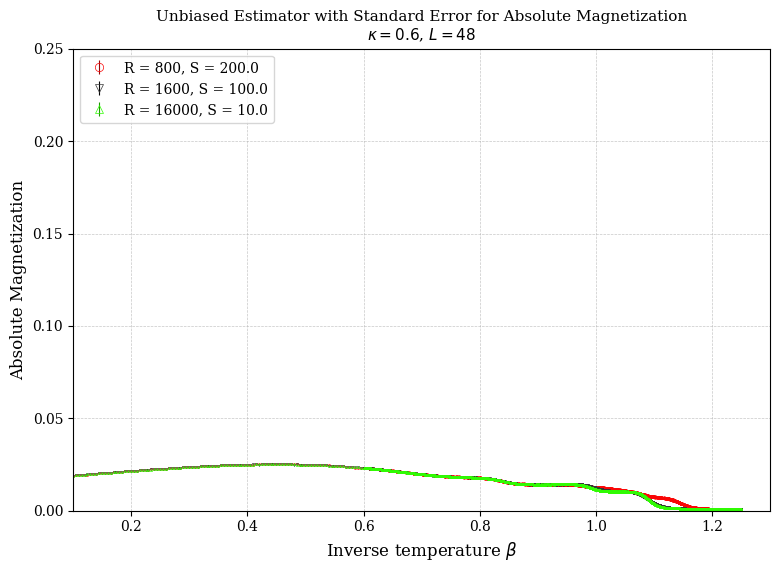

In [122]:
R_arr = np.array([800,1600,16000])
comparePopSize(0.6, 48, R_arr, qty = 5)

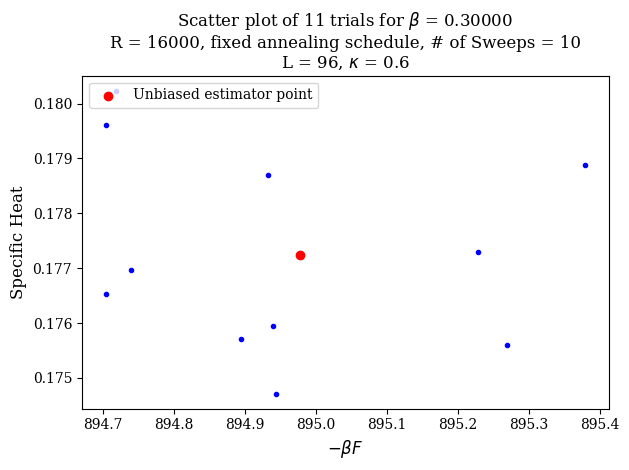

In [119]:
scatterData(0.6,96,16000,0.3,quantity = 6)

Specific Heat
No. of datasets = 11
Peaks at beta = [0.894  0.9774 1.038  1.0757 1.1135]
Heights at resp. peaks = [1.00804435 1.42245458 1.72127086 1.99826003 2.09907034]
Peak widths = [0.0365 0.0225 0.0204 0.0234 0.0256]
[ 707 1289 1895 2272 2650]


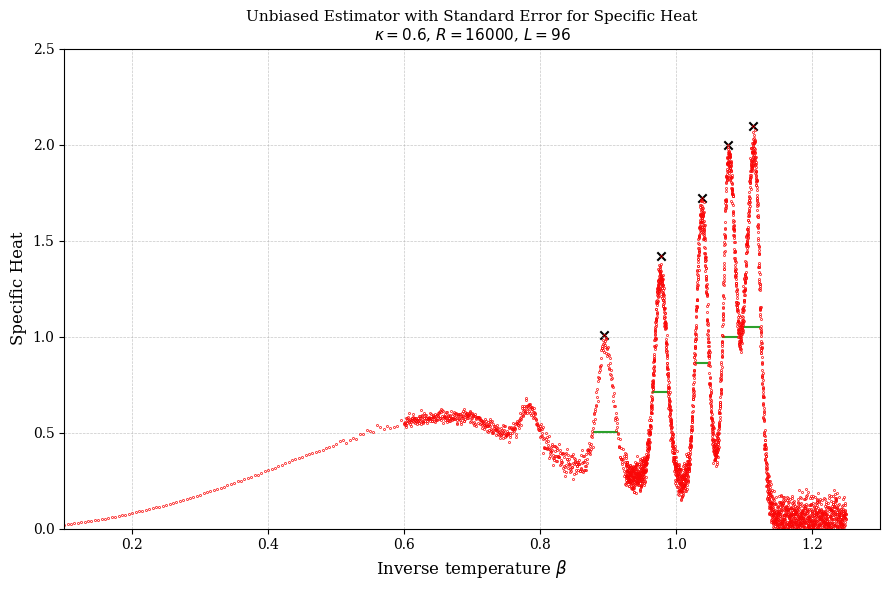

In [120]:
getPeakWidths(kappa = 0.6,L = 96, R = 16000)